In [1]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

# create spark contexts

sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [2]:
spark = SparkSession \
    .builder \
    .master("local[*]")\
    .appName("blogtext_preprocessing") \
    .getOrCreate()

In [3]:
spark.version

'2.4.4'

load blogtext.csv

In [4]:
blogtext_df = spark.read.csv('/spring2021/project1/blogtext.csv',header=True, inferSchema='true')

blogtext_df.show(5)

+-------+------+---+-----------------+--------+------------+--------------------+
|     id|gender|age|            topic|    sign|        date|                text|
+-------+------+---+-----------------+--------+------------+--------------------+
|2059027|  male| 15|          Student|     Leo| 14,May,2004|           Info h...|
|2059027|  male| 15|          Student|     Leo| 13,May,2004|           These ...|
|2059027|  male| 15|          Student|     Leo| 12,May,2004|           In het...|
|2059027|  male| 15|          Student|     Leo| 12,May,2004|           testin...|
|3581210|  male| 33|InvestmentBanking|Aquarius|11,June,2004|             Than...|
+-------+------+---+-----------------+--------+------------+--------------------+
only showing top 5 rows



In [5]:
blogtext_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- topic: string (nullable = true)
 |-- sign: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)



In [6]:
type(blogtext_df)

pyspark.sql.dataframe.DataFrame

In [7]:
blogtext_df.count()

681284

setup pyspark udf functions

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
import preproc as pp

# preproc is a python file that has functions defined to do the "text" column preprocessing.

# Register all the functions in Preproc with Spark Context

remove_stops_udf = udf(pp.remove_stops, StringType())
remove_features_udf = udf(pp.remove_features, StringType())
tag_and_remove_udf = udf(pp.tag_and_remove, StringType())
lemmatize_udf = udf(pp.lemmatize, StringType())


packages downloaded from nltk

In [9]:
#import nltk
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

remove stop words

In [10]:
# get the raw columns
raw_cols = blogtext_df.columns

rm_stops_df = blogtext_df.select(raw_cols)\
                   .withColumn("stop_text", remove_stops_udf(blogtext_df["text"]))

remove column "text" from "rm_stops_df".now we are going to use "stop_text" column which is the one with all the stopwords removed.

In [11]:
from functools import reduce
from pyspark.sql import DataFrame

rm_stops_df = reduce(DataFrame.drop, ['text'], rm_stops_df)
raw_cols = rm_stops_df.columns

remove irrelevant features

In [12]:
rm_features_df = rm_stops_df.select(raw_cols)\
                            .withColumn("feat_text", \
                            remove_features_udf(rm_stops_df["stop_text"]))


In [13]:
#remove column "stop_text" from "rm_stops_df".
#now we are going to use "feat_text" column which is the one with all the unwanted features removed.

rm_features_df = reduce(DataFrame.drop, ['stop_text'], rm_features_df)

raw_cols = rm_features_df.columns

tag the words

In [14]:
tagged_df = rm_features_df.select(raw_cols) \
                          .withColumn("tagged_text", \
                           tag_and_remove_udf(rm_features_df.feat_text))

In [15]:
#remove column "feat_text" from "rm_stops_df".
#now we are going to use "tagged_text" column which is the one with all the unwanted features removed.

tagged_df = reduce(DataFrame.drop, ['feat_text'], tagged_df)

raw_cols = tagged_df.columns

lemmatization of words

In [16]:
lemm_df = tagged_df.select(raw_cols) \
                   .withColumn("text", lemmatize_udf(tagged_df["tagged_text"]))

In [17]:
#remove column "tagged_text" from "rm_stops_df".
#now we are going to use "text" column which is the one with all the unwanted features removed.

lemm_df = reduce(DataFrame.drop, ['tagged_text'], lemm_df)

raw_cols = lemm_df.columns

In [18]:
# lemm_df is now clean

lemm_df.show(5)


+-------+------+---+-----------------+--------+------------+--------------------+
|     id|gender|age|            topic|    sign|        date|                text|
+-------+------+---+-----------------+--------+------------+--------------------+
|2059027|  male| 15|          Student|     Leo| 14,May,2004|info find page pd...|
|2059027|  male| 15|          Student|     Leo| 13,May,2004|team member drewe...|
|2059027|  male| 15|          Student|     Leo| 12,May,2004|het kader van ker...|
|2059027|  male| 15|          Student|     Leo| 12,May,2004|           test test|
|3581210|  male| 33|InvestmentBanking|Aquarius|11,June,2004|thanks yahoo tool...|
+-------+------+---+-----------------+--------+------------+--------------------+
only showing top 5 rows



Group data by topic

In [19]:
from pyspark.sql.functions import col

topic_count = lemm_df.groupBy("topic").count().orderBy(col("count").desc())

topic_count.count()

40

There are 40 interesting topics in the blog.

In [20]:
topic_count.show(truncate=False)

+--------------------+------+
|topic               |count |
+--------------------+------+
|indUnk              |251015|
|Student             |153903|
|Technology          |42055 |
|Arts                |32449 |
|Education           |29633 |
|Communications-Media|20140 |
|Internet            |16006 |
|Non-Profit          |14700 |
|Engineering         |11653 |
|Law                 |9040  |
|Publishing          |7753  |
|Science             |7269  |
|Government          |6907  |
|Consulting          |5862  |
|Religion            |5235  |
|Fashion             |4851  |
|Marketing           |4769  |
|Advertising         |4676  |
|BusinessServices    |4500  |
|Banking             |4049  |
+--------------------+------+
only showing top 20 rows



plot to show all the topics in the blog

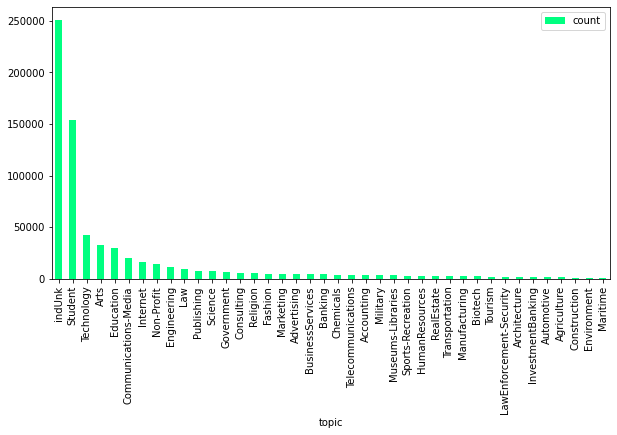

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
df_pandas = topic_count.toPandas()
df_pandas.plot(figsize = (10,5), kind='bar', x='topic', y='count', colormap='winter_r')
plt.show()

indUnk and Student are the topics highly discussed. Other topics have less than 50,000 records.

filter and analyse topic "indUnk"

In [23]:
topic_indUnk = lemm_df.select('text').filter(lemm_df.topic == "indUnk") 
topic_indUnk.count()

251015

converting the filtered dataframe to rdd

In [24]:
topic_indUnk_rdd = topic_indUnk.rdd.map(list)
topic_indUnk_rdd.take(2)

[['optimist pessimist argument nooooo stop think boyfriend allow obsess lot crazy think go work crazy think work think yes insane believe know go happen thing happen get hope drop flat face year make think different guy meet hurt way guy right course guy know break heart know gosh know'],
 ['look look eye see tear look eye gaze yours grief hope anguish love know see lock stare try freeze moment conversation pass word spoken unsure next run finger hair hug position odd becomes comfort thing entire world bell ring bell savior betray bell stand hand hand world go tell say back weekly say good bye walk twenty step look see watch fade memory run kiss perpetual kiss part walk warmth remain lip take huge part life entire heart kiss remember forget love good bye']]

removing the square brackets at the begin and end of each row

In [25]:
import re

topic_indUnk_rdd = topic_indUnk_rdd.map(lambda x: re.sub('\[|\]', '', str(x)))
topic_indUnk_rdd.take(2)

["'optimist pessimist argument nooooo stop think boyfriend allow obsess lot crazy think go work crazy think work think yes insane believe know go happen thing happen get hope drop flat face year make think different guy meet hurt way guy right course guy know break heart know gosh know'",
 "'look look eye see tear look eye gaze yours grief hope anguish love know see lock stare try freeze moment conversation pass word spoken unsure next run finger hair hug position odd becomes comfort thing entire world bell ring bell savior betray bell stand hand hand world go tell say back weekly say good bye walk twenty step look see watch fade memory run kiss perpetual kiss part walk warmth remain lip take huge part life entire heart kiss remember forget love good bye'"]

split rdd

In [26]:
split_rdd = topic_indUnk_rdd.flatMap(lambda line: line.split(" "))
split_rdd.take(20)

["'optimist",
 'pessimist',
 'argument',
 'nooooo',
 'stop',
 'think',
 'boyfriend',
 'allow',
 'obsess',
 'lot',
 'crazy',
 'think',
 'go',
 'work',
 'crazy',
 'think',
 'work',
 'think',
 'yes',
 'insane']

In [ ]:
#print("Total number of words in 'indUnk' topic:", split_rdd.count())

map each word with 1, then reduce by key(words), and finally sort by key(count)

In [31]:
map_rdd = split_rdd.map(lambda x: (x,1))
reduce_rdd = map_rdd.reduceByKey(lambda a,b: a+b)
sort_rdd = reduce_rdd.map(lambda x: (x[1],x[0])).sortByKey()

show word count for topic "indUnk"

In [33]:
#for word in sort_rdd.take(20):
    #print(word[1], word[0])
sort_rdd.take(20)    

[(1, "'aaarrrggghhhhhhhhgggghhhhhh"),
 (1, 'brianed'),
 (1, 'debbs'),
 (1, 'vickrey'),
 (1, 'intn'),
 (1, "'kaploink"),
 (1, 'dialkyl'),
 (1, 'dibacle'),
 (1, 'beastiest'),
 (1, 'galililiililii'),
 (1, 'riioot'),
 (1, 'soib'),
 (1, 'xxthe'),
 (1, 'putaran'),
 (1, 'megawati'),
 (1, 'tigas'),
 (1, 'hongry'),
 (1, 'urshur'),
 (1, 'thimbleful'),
 (1, 'silflay')]

In [68]:
sort_df = spark.createDataFrame(sort_rdd)

In [69]:
sort_df.show()

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  1|'aaarrrggghhhhhhh...|
|  1|             brianed|
|  1|               debbs|
|  1|             vickrey|
|  1|                intn|
|  1|           'kaploink|
|  1|             dialkyl|
|  1|             dibacle|
|  1|           beastiest|
|  1|      galililiililii|
|  1|              riioot|
|  1|                soib|
|  1|               xxthe|
|  1|             putaran|
|  1|            megawati|
|  1|               tigas|
|  1|              hongry|
|  1|              urshur|
|  1|          thimbleful|
|  1|             silflay|
+---+--------------------+
only showing top 20 rows



In [70]:
sort_df.select("_2").show()

+--------------------+
|                  _2|
+--------------------+
|'aaarrrggghhhhhhh...|
|             brianed|
|               debbs|
|             vickrey|
|                intn|
|           'kaploink|
|             dialkyl|
|             dibacle|
|           beastiest|
|      galililiililii|
|              riioot|
|                soib|
|               xxthe|
|             putaran|
|            megawati|
|               tigas|
|              hongry|
|              urshur|
|          thimbleful|
|             silflay|
+--------------------+
only showing top 20 rows



In [34]:
#import matplotlib.pyplot as plt

#num_bins = 50
#n, bins, patches = plt.hist(sort_rdd.collect(), num_bins, normed=1, facecolor='green', alpha=0.5)

filter and analyse topic "Student".following the same steps as we did with topic "indUnk"

In [35]:
topic_student = lemm_df.select('text').filter(lemm_df.topic == "Student") 
topic_student.count()

153903

In [36]:
topic_student_rdd = topic_student.rdd.map(list)
topic_student_rdd.take(2)

[['info find page pdf file wait untill team leader process learns html'],
 ['team member drewes van der laag urllink mail ruiyu xie urllink mail bryan aaldering urllink mail']]

In [37]:
#import re

topic_student_rdd = topic_student_rdd.map(lambda x: re.sub('\[|\]', '', str(x)))
topic_student_rdd.take(2)

["'info find page pdf file wait untill team leader process learns html'",
 "'team member drewes van der laag urllink mail ruiyu xie urllink mail bryan aaldering urllink mail'"]

In [38]:
split_rdd1 = topic_student_rdd.flatMap(lambda line: line.split(" "))
split_rdd1.take(20)

["'info",
 'find',
 'page',
 'pdf',
 'file',
 'wait',
 'untill',
 'team',
 'leader',
 'process',
 'learns',
 "html'",
 "'team",
 'member',
 'drewes',
 'van',
 'der',
 'laag',
 'urllink',
 'mail']

In [39]:
print("Total number of words in 'Student' topic:", split_rdd1.count())

Total number of words in 'Student' topic: 12788216


In [40]:
map_rdd1 = split_rdd1.map(lambda x: (x,1))
reduce_rdd1 = map_rdd1.reduceByKey(lambda a,b: a+b)
sort_rdd1 = reduce_rdd1.map(lambda x: (x[1],x[0])).sortByKey()

show word count for topic "Student"

In [41]:
#for word in sort_rdd1.take(20):
    #print(word[1], word[0])
sort_rdd1.take(20)    

[(1, 'dragonfruit'),
 (1, 'batallia'),
 (1, 'iways'),
 (1, 'bariloche'),
 (1, 'talko'),
 (1, 'shinsplints'),
 (1, 'delicioso'),
 (1, 'atestado'),
 (1, 'cagada'),
 (1, 'bidibidibumbum'),
 (1, 'vaaa'),
 (1, 'sopita'),
 (1, 'llevo'),
 (1, 'abrio'),
 (1, 'thear'),
 (1, "'stealthy"),
 (1, "sarachichita'"),
 (1, 'dificulty'),
 (1, 'asphxia'),
 (1, 'intacto')]

analyse topic "Technology"

In [42]:
topic_tech = lemm_df.select('text').filter(lemm_df.topic == "Technology") 
topic_tech.count()

42055

In [43]:
topic_tech_rdd = topic_tech.rdd.map(list)
topic_tech_rdd.take(2)

[['much funny point mention email game week research century poem final paper enjoy work swashbuckling adventure wintery hillsfar'],
 ['harper harper harper harper care harper harper stay motion harper harper heal potion harper harper pin green harper harper enter scene harper harper form bard harper harper get fuck kid jesus christ screw']]

In [44]:
topic_tech_rdd = topic_tech_rdd.map(lambda x: re.sub('\[|\]', '', str(x)))
topic_tech_rdd.take(2)

["'much funny point mention email game week research century poem final paper enjoy work swashbuckling adventure wintery hillsfar'",
 "'harper harper harper harper care harper harper stay motion harper harper heal potion harper harper pin green harper harper enter scene harper harper form bard harper harper get fuck kid jesus christ screw'"]

In [45]:
split_rdd2 = topic_tech_rdd.flatMap(lambda line: line.split(" "))
split_rdd2.take(20)

["'much",
 'funny',
 'point',
 'mention',
 'email',
 'game',
 'week',
 'research',
 'century',
 'poem',
 'final',
 'paper',
 'enjoy',
 'work',
 'swashbuckling',
 'adventure',
 'wintery',
 "hillsfar'",
 "'harper",
 'harper']

In [46]:
print("Total number of words in 'Technology' topic:", split_rdd2.count())

Total number of words in 'Technology' topic: 3040455


In [48]:
map_rdd2 = split_rdd2.map(lambda x: (x,1))
reduce_rdd2 = map_rdd2.reduceByKey(lambda a,b: a+b)
sort_rdd2 = reduce_rdd2.map(lambda x: (x[1],x[0])).sortByKey()

show word count for topic "Technology"

In [49]:
#for word in sort_rdd2.take(50):
    #print(word[1], word[0])
sort_rdd2.take(20)    

[(1, 'cormanthor'),
 (1, 'benevloent'),
 (1, "rigger'"),
 (1, 'dostoyevski'),
 (1, "aaaahh'"),
 (1, 'circlists'),
 (1, 'carytown'),
 (1, 'strassberger'),
 (1, 'shugborough'),
 (1, "garfield'"),
 (1, "imagining'"),
 (1, "'eyeball"),
 (1, "solstice'"),
 (1, 'malignancy'),
 (1, 'wisely'),
 (1, 'meandering'),
 (1, "caesar'"),
 (1, 'curtainloud'),
 (1, 'barnett'),
 (1, "ebert'")]

In [71]:
sort_df2 = spark.createDataFrame(sort_rdd2)
sort_df2.select("_2").show()

+------------+
|          _2|
+------------+
|  cormanthor|
|  benevloent|
|     rigger'|
| dostoyevski|
|     aaaahh'|
|   circlists|
|    carytown|
|strassberger|
| shugborough|
|   garfield'|
|  imagining'|
|    'eyeball|
|   solstice'|
|  malignancy|
|      wisely|
|  meandering|
|     caesar'|
| curtainloud|
|     barnett|
|      ebert'|
+------------+
only showing top 20 rows



analyse topic "Arts"

In [50]:
topic_arts = lemm_df.select('text').filter(lemm_df.topic == "Arts") 
topic_arts.count()

32449

In [51]:
topic_arts_rdd = topic_arts.rdd.map(list)
topic_arts_rdd.take(2)

[['current music magic donna summer feel blah late yeah post diary suchisthis server bitch vicky head kristen house bronx live matter spent night worth vicky ate lot chicken hot dog kill donut great fullfilling lol hour go go outside kristen neighbor light firework middle street cool start swift position go air go look go hit scream as run corner many come think purpose enjoy scream terrorize kristen blast laugh stand tomorrow hmm let as get burn block night ritual burning ritual lol vicky kristen burn everything plastic cup pop rock haha great think kristen slight fetish hot wax keep pour candle wrong know hot burn feel good try pours let ahh worry feel little darish tell flash air show thier bra pussy say like do anything let see do flash air feminine part know breast burn half cup ruin poor cement head night take shower get kris vicky come bathroom shower thier clothes world sharice come gonna fun get wash half little towel get soak know say fuck take naked great start wash thier ha

In [52]:
topic_arts_rdd = topic_arts_rdd.map(lambda x: re.sub('\[|\]', '', str(x)))
topic_arts_rdd.take(2)

["'current music magic donna summer feel blah late yeah post diary suchisthis server bitch vicky head kristen house bronx live matter spent night worth vicky ate lot chicken hot dog kill donut great fullfilling lol hour go go outside kristen neighbor light firework middle street cool start swift position go air go look go hit scream as run corner many come think purpose enjoy scream terrorize kristen blast laugh stand tomorrow hmm let as get burn block night ritual burning ritual lol vicky kristen burn everything plastic cup pop rock haha great think kristen slight fetish hot wax keep pour candle wrong know hot burn feel good try pours let ahh worry feel little darish tell flash air show thier bra pussy say like do anything let see do flash air feminine part know breast burn half cup ruin poor cement head night take shower get kris vicky come bathroom shower thier clothes world sharice come gonna fun get wash half little towel get soak know say fuck take naked great start wash thier ha

In [53]:
split_rdd3 = topic_arts_rdd.flatMap(lambda line: line.split(" "))
split_rdd3.take(20)

["'current",
 'music',
 'magic',
 'donna',
 'summer',
 'feel',
 'blah',
 'late',
 'yeah',
 'post',
 'diary',
 'suchisthis',
 'server',
 'bitch',
 'vicky',
 'head',
 'kristen',
 'house',
 'bronx',
 'live']

In [54]:
#print("Total number of words in 'Arts' topic:", split_rdd3.count())

Total number of words in 'Arts' topic: 2949699


In [55]:
map_rdd3 = split_rdd3.map(lambda x: (x,1))
reduce_rdd3 = map_rdd3.reduceByKey(lambda a,b: a+b)
sort_rdd3 = reduce_rdd3.map(lambda x: (x[1],x[0])).sortByKey()

show word count for topic "Arts"

In [56]:
#for word in sort_rdd3.take(50):
    #print(word[1], word[0])
sort_rdd3.take(20)    

[(1, 'isipin'),
 (1, 'joga'),
 (1, 'nackered'),
 (1, 'tothom'),
 (1, 'fianceee'),
 (1, "steffen'"),
 (1, 'ffrench'),
 (1, 'trainees'),
 (1, 'theologicae'),
 (1, 'zyprexa'),
 (1, "heck'"),
 (1, 'trendwhore'),
 (1, 'secondborn'),
 (1, 'kirshenbaum'),
 (1, 'dontcha'),
 (1, 'sissssssy'),
 (1, 'ladylike'),
 (1, 'invovles'),
 (1, "'mortal"),
 (1, "trucker'")]

In [72]:
sort_df3 = spark.createDataFrame(sort_rdd3)
sort_df3.select("_2").show()

+-----------+
|         _2|
+-----------+
|     isipin|
|       joga|
|   nackered|
|     tothom|
|   fianceee|
|   steffen'|
|    ffrench|
|   trainees|
|theologicae|
|    zyprexa|
|      heck'|
| trendwhore|
| secondborn|
|kirshenbaum|
|    dontcha|
|  sissssssy|
|   ladylike|
|   invovles|
|    'mortal|
|   trucker'|
+-----------+
only showing top 20 rows



analyse topic "Education"

In [57]:
topic_edu = lemm_df.select('text').filter(lemm_df.topic == "Education") 
topic_edu.count()

29633

In [58]:
topic_edu_rdd = topic_edu.rdd.map(list)
topic_edu_rdd.take(2)

[['morning wake think day bed early hate get morning morning person morning person talk wake growl sweet tying rouse crave saturday wake deadline sleep go minute weekday begin perk start make coffee thank god coffee think make day snore end making day fight hell take nap afternoon hour become problem revolve fact stay til everynight teach school way real reason write novel develop photograph knit amazing sweater catch do nothing guess say night read watch read blog online talk west coast friend use stay watch letterman bore night owl remember stay late start elmentary school middle school remember watch saturday night live johnny carson family know quality bonding time remember college wish exam give night brain much alert convince improve grade wake everynight begin get thing do dish laundry phone call email project organize hour second remember want bed early feel shit morning roll think give hour think bed midnight get hour sleep sound good happens everynight stay thing bring enligh

In [59]:
topic_edu_rdd = topic_edu_rdd.map(lambda x: re.sub('\[|\]', '', str(x)))
topic_edu_rdd.take(2)

["'morning wake think day bed early hate get morning morning person morning person talk wake growl sweet tying rouse crave saturday wake deadline sleep go minute weekday begin perk start make coffee thank god coffee think make day snore end making day fight hell take nap afternoon hour become problem revolve fact stay til everynight teach school way real reason write novel develop photograph knit amazing sweater catch do nothing guess say night read watch read blog online talk west coast friend use stay watch letterman bore night owl remember stay late start elmentary school middle school remember watch saturday night live johnny carson family know quality bonding time remember college wish exam give night brain much alert convince improve grade wake everynight begin get thing do dish laundry phone call email project organize hour second remember want bed early feel shit morning roll think give hour think bed midnight get hour sleep sound good happens everynight stay thing bring enligh

In [60]:
split_rdd4 = topic_edu_rdd.flatMap(lambda line: line.split(" "))
split_rdd4.take(20)

["'morning",
 'wake',
 'think',
 'day',
 'bed',
 'early',
 'hate',
 'get',
 'morning',
 'morning',
 'person',
 'morning',
 'person',
 'talk',
 'wake',
 'growl',
 'sweet',
 'tying',
 'rouse',
 'crave']

In [61]:
#print("Total number of words in 'Education' topic:", split_rdd4.count())

In [62]:
map_rdd4 = split_rdd4.map(lambda x: (x,1))
reduce_rdd4 = map_rdd4.reduceByKey(lambda a,b: a+b)
sort_rdd4 = reduce_rdd4.map(lambda x: (x[1],x[0])).sortByKey()

show word count for topic "Education"

In [63]:
#for word in sort_rdd4.take(50):
    #print(word[1], word[0])
sort_rdd4.take(20)    

[(1, 'pkwy'),
 (1, 'carytown'),
 (1, 'quetions'),
 (1, 'professionalhood'),
 (1, 'foxfields'),
 (1, 'cigarretes'),
 (1, 'youalways'),
 (1, 'scrutinise'),
 (1, 'vio'),
 (1, 'plastisin'),
 (1, 'alwiz'),
 (1, 'metagrobolizing'),
 (1, 'leet'),
 (1, "'blogg"),
 (1, 'turux'),
 (1, "abou'"),
 (1, 'sydneysiders'),
 (1, 'spealing'),
 (1, 'livermores'),
 (1, 'pathless')]

In [65]:
sort_df4 = spark.createDataFrame(sort_rdd4) 

In [66]:
sort_df4.show()

+---+----------------+
| _1|              _2|
+---+----------------+
|  1|            pkwy|
|  1|        carytown|
|  1|        quetions|
|  1|professionalhood|
|  1|       foxfields|
|  1|      cigarretes|
|  1|       youalways|
|  1|      scrutinise|
|  1|             vio|
|  1|       plastisin|
|  1|           alwiz|
|  1| metagrobolizing|
|  1|            leet|
|  1|          'blogg|
|  1|           turux|
|  1|           abou'|
|  1|    sydneysiders|
|  1|        spealing|
|  1|      livermores|
|  1|        pathless|
+---+----------------+
only showing top 20 rows



In [67]:
sort_df4.select("_2").show()

+----------------+
|              _2|
+----------------+
|            pkwy|
|        carytown|
|        quetions|
|professionalhood|
|       foxfields|
|      cigarretes|
|       youalways|
|      scrutinise|
|             vio|
|       plastisin|
|           alwiz|
| metagrobolizing|
|            leet|
|          'blogg|
|           turux|
|           abou'|
|    sydneysiders|
|        spealing|
|      livermores|
|        pathless|
+----------------+
only showing top 20 rows

